# Introduction
In this notebook we implement the Perceptron Learning Algorithm.

- Algorithms: Perceptron Learning Algorithm (PLA) and the Pocket extension
- DataSets:   "perceptron" and "pocket"
- Video: To Be Added


# Perceptron
The hypothesis set for the Perceptron is

$$ H=\{h(x)=\text{sign}(w^T x) \mid w\in R^{d+1}\}$$

Given data $D=\{(x_1, y_1), ..., (x_N, y_N)\}$ we want to minimize the following error function  

$$E_{in}(h)=\sum_{i=1}^N \mathbb{1}_{h(x_i)\neq y_i} $$

Here $\mathbb{1}_{h(x_i)\neq y_i}$ is the indicator function 

$$\mathbb{1}_{h(x_i)\neq y_i} = \begin{cases}
1 &\text{if }h(x_i) \neq y_i\\
0 &\text{else}
\end{cases}$$

Notice that any hypothesis $h(x)=\text{sign}(w^Tx)\in H$ is described exactly by its weights $w\in R^{d+1}$. Our goal is to find weights $w$ such that we minimize the in-sample error $E_{in}$. Consider the following data

In [3]:
import dataset as ds

data = ds.DataSet("perceptron")
data.plot() 

Notice that the two groups of points could be seperated by a line. We say that the data is *linearly seperable*. The following algorithm is called the Perceptron Learning Algorithm. If the data is *linearly seperable* it will find a seperating line. This will make the perceptron classify all points correctly and thus get $E_{in}(h)=0$ !

       Perceptron Learning Algorithm
       w = initialize random
       while there is a misclassified point x in D
          pick misclassified point x
          update weights w = w + learning_rate * x * y
      
It can be proved that 

$$\text{D is linearly seperable}\quad\Rightarrow \quad\text{The PLA algorithm finds a seperating hyperplane in finite steps}$$

Several proofs are available online [1,2,3] (the proof is not a part of the AU ML 2017 curriculum). 

# Code: Perceptron 
The following code implements the class `Perceptron`. For simplicity all visualization code has been moved to `hide_visualization_code`. 

<IPython.core.display.Javascript object>


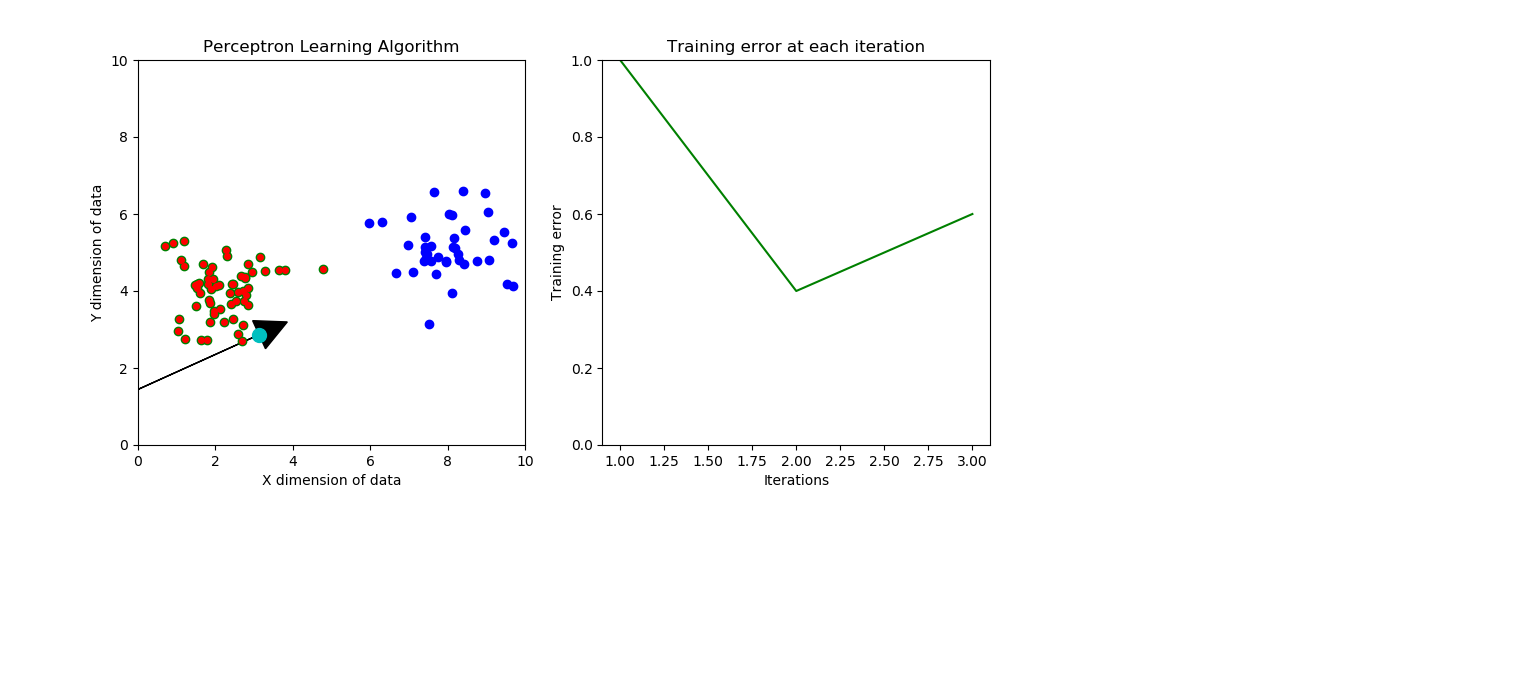

/home/ubudevml/Desktop/MLNotebooks/AU ML course/exam help/Linear Models/hide_visualization_code.py:55: RuntimeWarning: invalid value encountered in double_scalars
  y0 = (-w[1]*0 - w[0]) / w[2]
/home/ubudevml/Desktop/MLNotebooks/AU ML course/exam help/Linear Models/hide_visualization_code.py:56: RuntimeWarning: invalid value encountered in double_scalars
  y1 = (-w[1]*10 - w[0]) / w[2]
/home/ubudevml/Desktop/MLNotebooks/AU ML course/exam help/Linear Models/hide_visualization_code.py:90: RuntimeWarning: invalid value encountered in double_scalars
  f_a = -w[1]/w[2]
/home/ubudevml/Desktop/MLNotebooks/AU ML course/exam help/Linear Models/hide_visualization_code.py:91: RuntimeWarning: invalid value encountered in double_scalars
  f_b = -w[0]/w[2]


KeyboardInterrupt: 

In [1]:
%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np
import time
import dataset as ds
import hide_visualization_code

class Perceptron:

    def __init__(self, learning_rate=0.01, visualize=False, sleep=0.0):
        self.w = None
        self.learning_rate = learning_rate
        self.visualize = visualize
        self.sleep = sleep
        
        if self.visualize: 
            hide_visualization_code.init_perceptron(self)
            
    def fit(self, X, y):
        """ Train the Perceptron on data X with labels y. 
        
        Parameters
        ----------
        X:    Matrix with shape (n, d) with data point x_i as the i'th row.   
        y:    Array with shape (n, ) with label y_i on the i'th entry. 
        """
        n, d = X.shape
        
        # Initialize weights 
        self.w = np.zeros(d)
        
        # Get a misclassified point. If all are classified correctly, the 
        # function will return False. 
        all_classified_corectly, misclassified_point, misclassified_label = self.misclassified(X, y)

        while not all_classified_corectly:
            # Visualize if enabled
            if self.visualize: self.visualize_step(X, y)
            
            # Update weights
            self.w += self.learning_rate * misclassified_point * misclassified_label
        
            # Get a new misclassified point. 
            all_classified_corectly, misclassified_point, misclassified_label = self.misclassified(X, y)
            
        # Visualize the last round if enabled
        if self.visualize: self.visualize_step(X, y)

    def misclassified(self, X, y):
        """ Finds a misclassified label, returns False if all points are correctly classified. 
        
        Parameters
        ----------
        X:    Matrix with shape (n, d) with data point x_i as the i'th row.   
        y:    Array with shape (n, ) with label y_i on the i'th entry. 
        
        Returns
        -------
        misclassified_point:    The miss classified point, if no such point return False. 
        misclassified_label:    The label of the miss classified point, if no such point return False. 
        """
        # Predict the class of each data point. 
        predictions = self.predict(X)
        
        # Get the number of miss classified points
        misclassified_count = sum(predictions != y)
        
        # Return False if all points are correctly classified. 
        if misclassified_count == 0: return True, None, None
        
        # Filter out the points where predictions disagree with labels. 
        misclassified_points = X[predictions != y]
        misclassified_labels = y[predictions != y]
        
        # Return te first miss classified point
        return False, misclassified_points[0], misclassified_labels[0]
        
    def error(self, X, y):
        """ Compute the error """
        n, d = X.shape
        return 1/n * sum(self.predict(X) != y) 
    
    def predict(self, X):
        """ Predicts the class of X given the trained weights. """
        return np.sign(X @ self.w)
    
    def visualize_step(self, X, y, subclass=False): 
        hide_visualization_code.visualize_perceptron(self, X, y, subclass)


# Generate data and run fit the Perceptron to the data. 
data = ds.DataSet("perceptron")       
perceptron = Perceptron(learning_rate=1, visualize=True, sleep=0.78)
perceptron.fit(data.X, data.y)

# Code: The Pocket Algorithm

The following code implements the class `Pocket`. It is a simple modification of the class `Perceptron`. It runs $T$ iterations and returns the best hypothesis of the $T$ hypothesis. The visualization plots the best hypothesis soo far with dashed lines. 

<IPython.core.display.Javascript object>


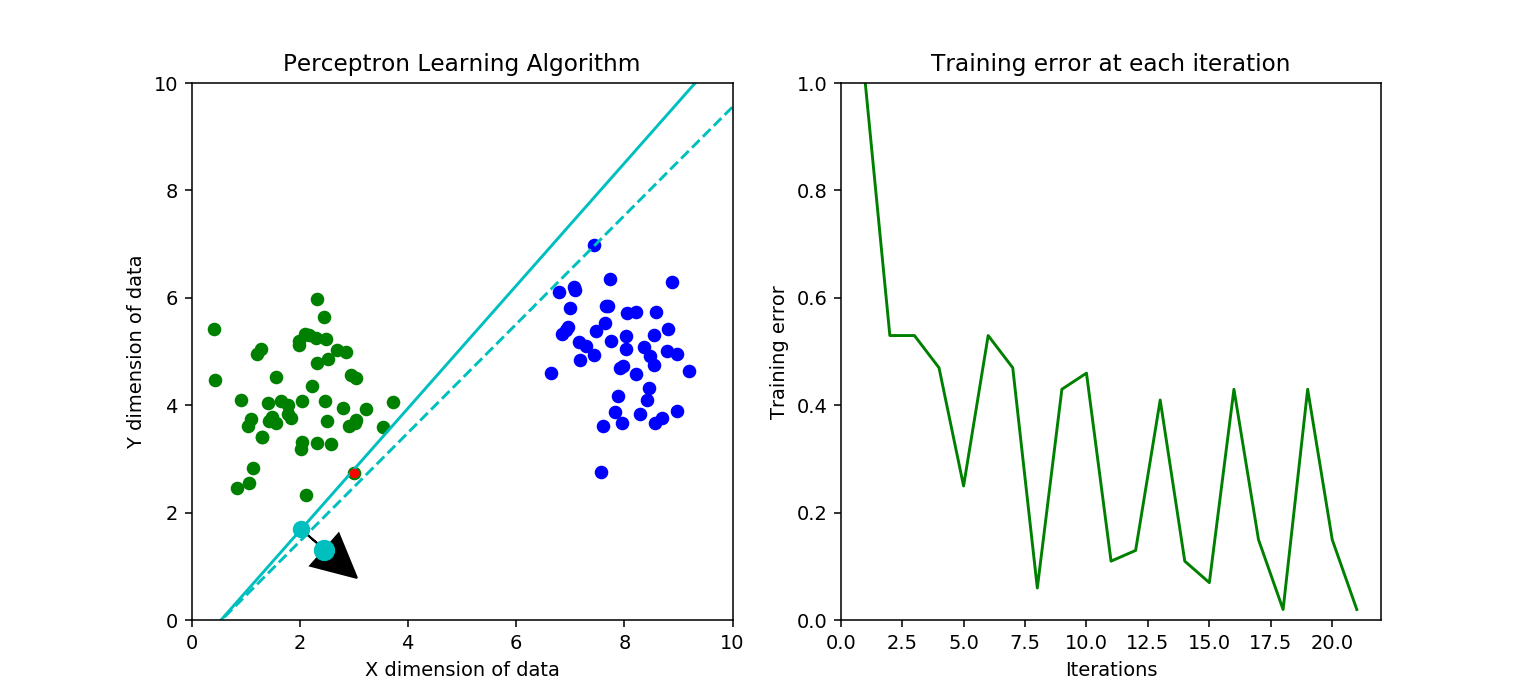

/home/ubudevml/Desktop/MLNotebooks/AU ML course/exam help/Linear Models/hide_visualization_code.py:55: RuntimeWarning: invalid value encountered in double_scalars
  y0 = (-w[1]*0 - w[0]) / w[2]
/home/ubudevml/Desktop/MLNotebooks/AU ML course/exam help/Linear Models/hide_visualization_code.py:56: RuntimeWarning: invalid value encountered in double_scalars
  y1 = (-w[1]*10 - w[0]) / w[2]
/home/ubudevml/Desktop/MLNotebooks/AU ML course/exam help/Linear Models/hide_visualization_code.py:90: RuntimeWarning: invalid value encountered in double_scalars
  f_a = -w[1]/w[2]
/home/ubudevml/Desktop/MLNotebooks/AU ML course/exam help/Linear Models/hide_visualization_code.py:91: RuntimeWarning: invalid value encountered in double_scalars
  f_b = -w[0]/w[2]
/home/ubudevml/Desktop/MLNotebooks/AU ML course/exam help/Linear Models/hide_visualization_code.py:8: RuntimeWarning: invalid value encountered in double_scalars
  y0 = (-w_[1]*0 - w_[0]) / w_[2]
/home/ubudevml/Desktop/MLNotebooks/AU ML course/exa

In [2]:
class Pocket(Perceptron): 
    
    def fit(self, X, y, T):
        """ Train the Perceptron on data X with labels y. At each iteration evaluate the performance
        of the current weights. Save the weights with the best performance and return these weights
        after T iterations. """
        n, d = X.shape
        
        # Initialize weights 
        self.w = np.zeros(d)
        
        # Get a misclassified point. If all are classified correctly, the 
        # function will return False. 
        all_classified_corectly, misclassified_point, misclassified_label = self.misclassified(X, y)
        
        # Initialize best error to the worst
        best_error = 1.0
        self.best_w = np.zeros(d)

        for i in range(T): 
            # Visualize if enabled
            if self.visualize: self.visualize_step(X, y)
            
            # Update weights
            self.w += self.learning_rate * misclassified_point * misclassified_label
        
            # If current error is better than previous update best error and 
            # best weights. 
            current_error = self.error(X, y)
            if current_error < best_error: 
                best_error = current_error
                self.best_w = np.copy(self.w) # copy and save the best weights. 
        
            # Get a new misclassified point. 
            all_classified_corectly, misclassified_point, misclassified_label = self.misclassified(X, y)
            
        # Visualize the last round if enabled
        if self.visualize: self.visualize_step(X, y)
            
    def visualize_step(self, X, y):
        # Let Perceptron draw step as usually
        super().visualize_step(X, y, subclass=True)
        hide_visualization_code.visualize_pocket(self, X, y)

data = ds.DataSet("perceptron")
pocket = Pocket(learning_rate = 1, visualize = True, sleep=0.78)
pocket.fit(data.X, data.y, 20)

# References
[1] http://www.cs.columbia.edu/~mcollins/courses/6998-2012/notes/perc.converge.pdf

[2] https://ocw.mit.edu/courses/electrical-engineering-and-computer-science/6-867-machine-learning-fall-2006/lecture-notes/lec2.pdf

[3] http://www.cems.uvm.edu/~rsnapp/teaching/cs295ml/notes/perceptron.pdf

# Errors, Suggestions and Hall Of Fame
If you find any mistakes or have suggestions for improvements reach me at alexmath@cs.au.dk. Any help is very much appreciated, I'll even add your name below for super-awesome everlasting fame!

- ...

# Discussion

<iframe src="..discussionboard/perceptron.html" style="width: 800px; height: 800px; "/></iframe>